In [3]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)

In [4]:
data = pd.read_csv('../data/processed_data.csv')
data = data[data['yyyymm'] % 100 == 12] # restrict sample size

### PCR

In [3]:
def pcr_search_best(X_train, y_train, X_val, y_val):
    best_pca = None
    best_ols = None
    best_val_score = float("-inf")
     
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_val = std_scaler.transform(X_val)
    
    for K in range(2, 103):
        """ First Step: PCA """
        pca = PCA(n_components=K)
        temp_X_train = pca.fit_transform(X_train)
        temp_X_val = pca.transform(X_val)

        """ Second Step: Standard Regression """
        ols = LinearRegression()
        ols.fit(temp_X_train, y_train)
        y_val_pred = ols.predict(temp_X_val)
        val_score = r2_score(y_val, y_val_pred)
        if val_score > best_val_score:
            best_pca = pca
            best_ols = ols
            best_val_score = val_score
            
    return std_scaler, best_pca, best_ols

In [4]:
# recursive evaluation
predictors = [v for v in list(data.columns) if v not in ['permno', 'yyyymm', 'RET']]
test_score = [0] * 30
models = []

for i in range(30):
    data_train = data[(data.yyyymm >= 196001 + i * 100) & (data.yyyymm < 197801 + i * 100)]
    data_validation = data[(data.yyyymm >= 197801 + i * 100) & (data.yyyymm < 199001 + i * 100)]
    data_test = data[(data.yyyymm >= 199001 + i*100) & (data.yyyymm < 199101 + i * 100)]
    print(f'batch {i}')
    print(f'train: {1960 + i}-{1978 + i}  size: {len(data_train)}')
    print(f'validate: {1978 + i}-{1990 + i}  size: {len(data_validation)}')
    print(f'test: {1990 + i}-{1991 + i}  size: {len(data_test)}')

    #Normalize
    X_train = data_train[predictors]
    X_validation = data_validation[predictors]
    X_test = data_test[predictors]

    y_train = data_train["RET"]
    y_validation = data_validation["RET"]
    y_test = data_test["RET"]
    
    std_scaler, pca, ols = pcr_search_best(X_train, y_train, X_validation, y_validation)
    
    X_test = pca.transform(std_scaler.transform(X_test))
    y_test_pred = ols.predict(X_test)
    test_score[i] = r2_score(y_test, y_test_pred)
    models.append([std_scaler, pca, ols])

batch 0
train: 1960-1978  size: 52060
validate: 1978-1990  size: 71704
test: 1990-1991  size: 6704
batch 1
train: 1961-1979  size: 55788
validate: 1979-1991  size: 73566
test: 1991-1992  size: 6788
batch 2
train: 1962-1980  size: 59446
validate: 1980-1992  size: 75555
test: 1992-1993  size: 6905
batch 3
train: 1963-1981  size: 62356
validate: 1981-1993  size: 77503
test: 1993-1994  size: 7638
batch 4
train: 1964-1982  size: 65654
validate: 1982-1994  size: 79786
test: 1994-1995  size: 8182
batch 5
train: 1965-1983  size: 69030
validate: 1983-1995  size: 82472
test: 1995-1996  size: 8396
batch 6
train: 1966-1984  size: 72971
validate: 1984-1996  size: 84783
test: 1996-1997  size: 9016
batch 7
train: 1967-1985  size: 77073
validate: 1985-1997  size: 87506
test: 1997-1998  size: 9140
batch 8
train: 1968-1986  size: 81176
validate: 1986-1998  size: 90346
test: 1998-1999  size: 8744
batch 9
train: 1969-1987  size: 85625
validate: 1987-1999  size: 92452
test: 1999-2000  size: 8379
batch 10
t

Text(0, 0.5, 'score--R-square')

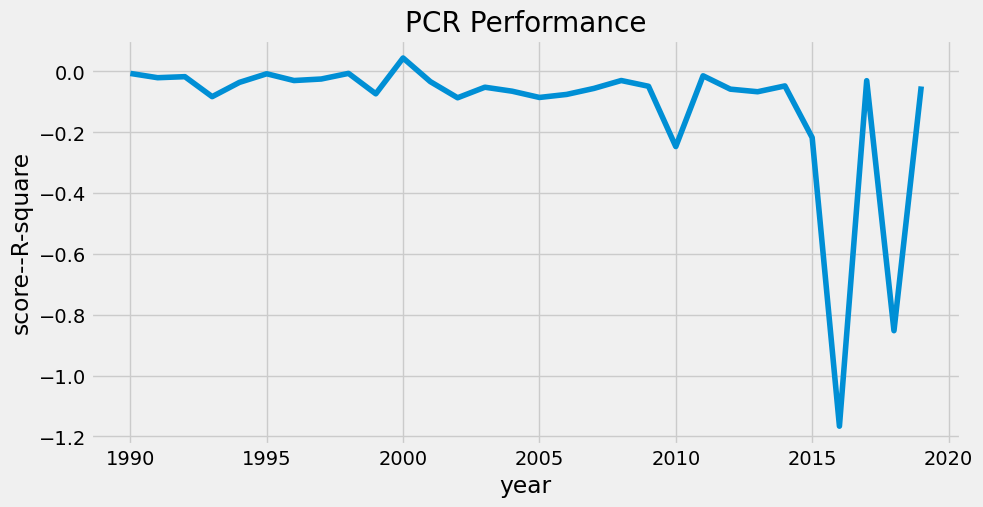

In [5]:
# Performence of PCR models
plt.figure(figsize=(10,5))
plt.title("PCR Performance")
year=np.arange(1990, 2020)
plt.plot(year, test_score)
plt.xlabel("year")
plt.ylabel("score--R-square")

Text(0, 0.5, 'complexity')

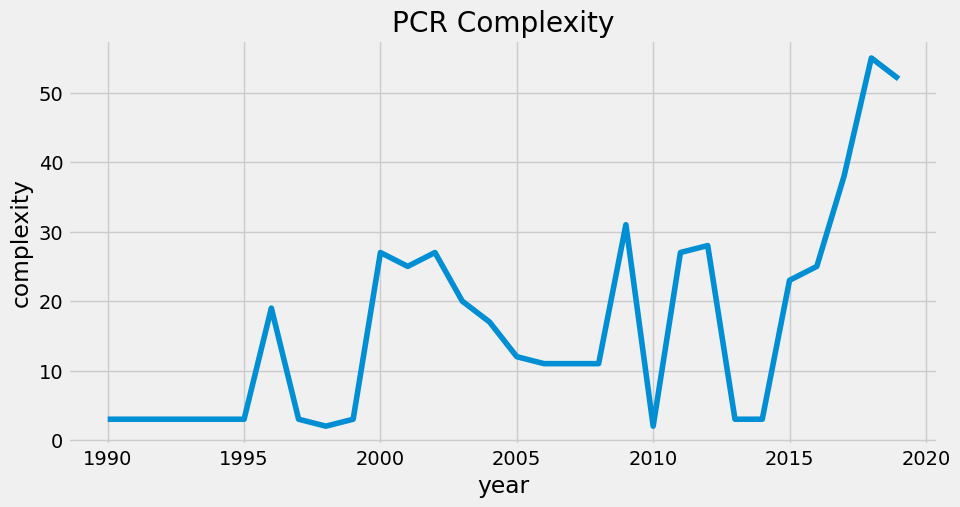

In [6]:
# Model complexities PCR
complexities = [0] * 30
for i, m in enumerate(models):
    complexities[i] = (m[1].n_components_)

plt.figure(figsize=(10,5))
plt.title("PCR Complexity")
year=np.arange(1990, 2020)
plt.plot(year, complexities)
plt.xlabel("year")
plt.ylabel("complexity")

In [7]:
#Variable importance
var_importance = np.zeros([30, len(predictors)])
for i in range(30):
    std_scaler, pca, ols = models[i][0], models[i][1], models[i][2]
    d = data[(data.yyyymm >= 199001 + i*100) & (data.yyyymm < 199101 + i * 100)]
    X = d[predictors]
    y = d['RET']
    for j in range(len(predictors)):
        X_mod = X.copy()  # numpy array
        X_mod.loc[:, predictors[j]] = 0
        X_mod = pca.transform(std_scaler.transform(X_mod)) 
        score = r2_score(y, ols.predict(X_mod))
        var_importance[i][j] = test_score[i] - score
        del X_mod

<Axes: ylabel='predictor'>

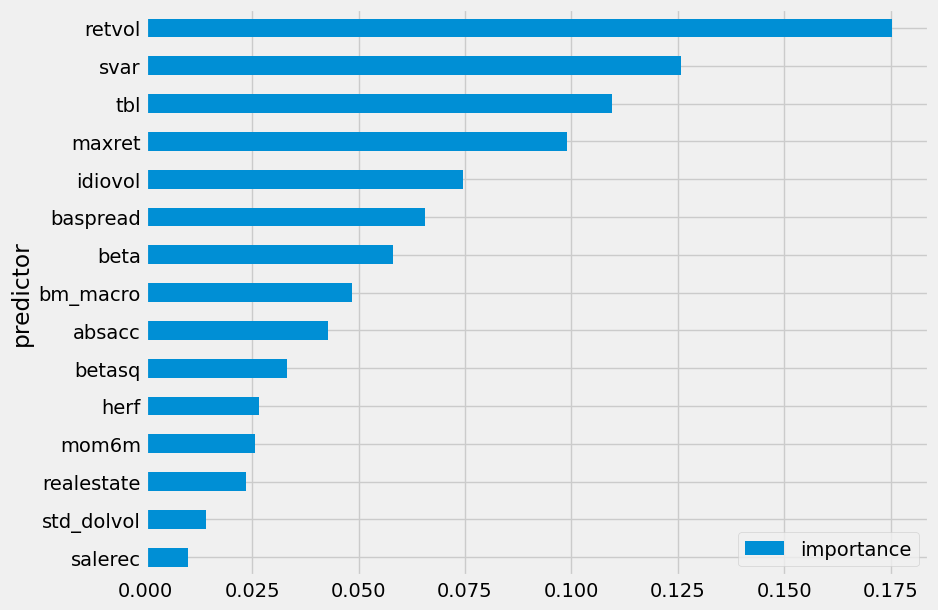

In [8]:
var_importance_agg = var_importance.sum(axis=0)
var_importance_agg[var_importance_agg < 0] = 0
var_importance_agg = var_importance_agg / var_importance_agg.sum()

var_importance_df = pd.DataFrame({'predictor': predictors, 'importance': var_importance_agg})
var_importance_df = var_importance_df.sort_values(by='importance',ascending=True).tail(15)
var_importance_df.plot.barh(x = 'predictor', y = 'importance', figsize = (9, 7))

<Axes: ylabel='predictor'>

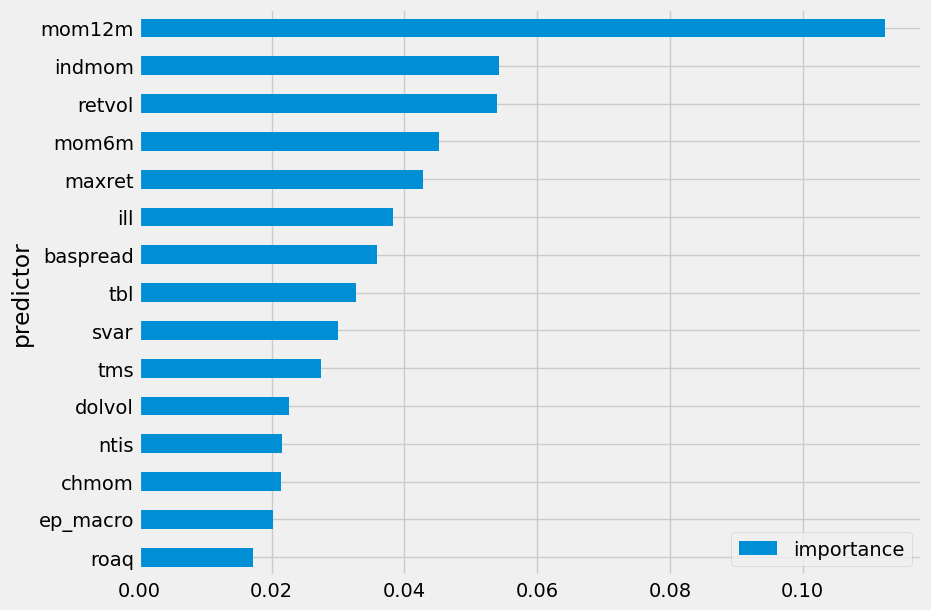

In [9]:
# SSD importance
ssd_list = [0] * 30
for i, m in enumerate(models):
    beta = m[2].coef_  # (n_components, )
    mat = m[1].components_  # (n_components, n_features)
    ssd_list[i] = np.matmul(mat.transpose(), beta) ** 2
ssd_importance = np.array(ssd_list).sum(axis=0)
ssd_importance = ssd_importance / ssd_importance.sum()

ssd_importance_df = pd.DataFrame({'predictor': predictors, 'importance': ssd_importance})
ssd_importance_df = ssd_importance_df.sort_values(by='importance',ascending=True).tail(15)
ssd_importance_df.plot.barh(x = 'predictor', y = 'importance', figsize = (9, 7))

### PLS

In [5]:
def pls_search_best(X_train, y_train, X_val, y_val):
    best_pls = None
    best_val_score = float("-inf")
     
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_val = std_scaler.transform(X_val)
    
    for K in range(2, 103):
        pls = PLSRegression(n_components=K)
        pls.fit(X_train, y_train)
        y_val_pred = pls.predict(X_val)
        val_score = r2_score(y_val, y_val_pred)
        if val_score > best_val_score:
            best_pls = pls
            best_val_score = val_score
            
    return std_scaler, best_pls

In [6]:
# recursive evaluation
predictors = [v for v in list(data.columns) if v not in ['permno', 'yyyymm', 'RET']]
test_score = [0] * 30
models = []

for i in range(30):
    data_train = data[(data.yyyymm >= 196001 + i * 100) & (data.yyyymm < 197801 + i * 100)]
    data_validation = data[(data.yyyymm >= 197801 + i * 100) & (data.yyyymm < 199001 + i * 100)]
    data_test = data[(data.yyyymm >= 199001 + i*100) & (data.yyyymm < 199101 + i * 100)]
    print(f'batch {i}')
    print(f'train: {1960 + i}-{1978 + i}  size: {len(data_train)}')
    print(f'validate: {1978 + i}-{1990 + i}  size: {len(data_validation)}')
    print(f'test: {1990 + i}-{1991 + i}  size: {len(data_test)}')

    #Normalize
    X_train = data_train[predictors]
    X_validation = data_validation[predictors]
    X_test = data_test[predictors]

    y_train = data_train["RET"]
    y_validation = data_validation["RET"]
    y_test = data_test["RET"]
    
    std_scaler, pls = pls_search_best(X_train, y_train, X_validation, y_validation)
    
    X_test = std_scaler.transform(X_test)
    y_test_pred = pls.predict(X_test)
    test_score[i] = r2_score(y_test,y_test_pred)
    models.append([std_scaler, pls])

batch 0
train: 1960-1978  size: 52060
validate: 1978-1990  size: 71704
test: 1990-1991  size: 6704
batch 1
train: 1961-1979  size: 55788
validate: 1979-1991  size: 73566
test: 1991-1992  size: 6788
batch 2
train: 1962-1980  size: 59446
validate: 1980-1992  size: 75555
test: 1992-1993  size: 6905
batch 3
train: 1963-1981  size: 62356
validate: 1981-1993  size: 77503
test: 1993-1994  size: 7638
batch 4
train: 1964-1982  size: 65654
validate: 1982-1994  size: 79786
test: 1994-1995  size: 8182
batch 5
train: 1965-1983  size: 69030
validate: 1983-1995  size: 82472
test: 1995-1996  size: 8396
batch 6
train: 1966-1984  size: 72971
validate: 1984-1996  size: 84783
test: 1996-1997  size: 9016
batch 7
train: 1967-1985  size: 77073
validate: 1985-1997  size: 87506
test: 1997-1998  size: 9140
batch 8
train: 1968-1986  size: 81176
validate: 1986-1998  size: 90346
test: 1998-1999  size: 8744
batch 9
train: 1969-1987  size: 85625
validate: 1987-1999  size: 92452
test: 1999-2000  size: 8379
batch 10
t

Text(0, 0.5, 'score--R-square')

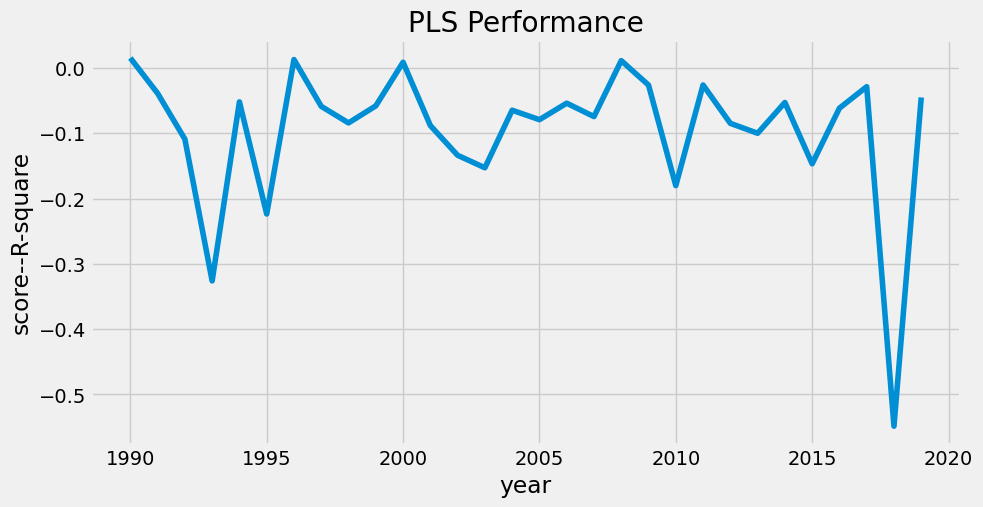

In [7]:
# Performence of PLS models
plt.figure(figsize=(10,5))
plt.title("PLS Performance")
year=np.arange(1990, 2020)
plt.plot(year, test_score)
plt.xlabel("year")
plt.ylabel("score--R-square")

Text(0, 0.5, 'complexity')

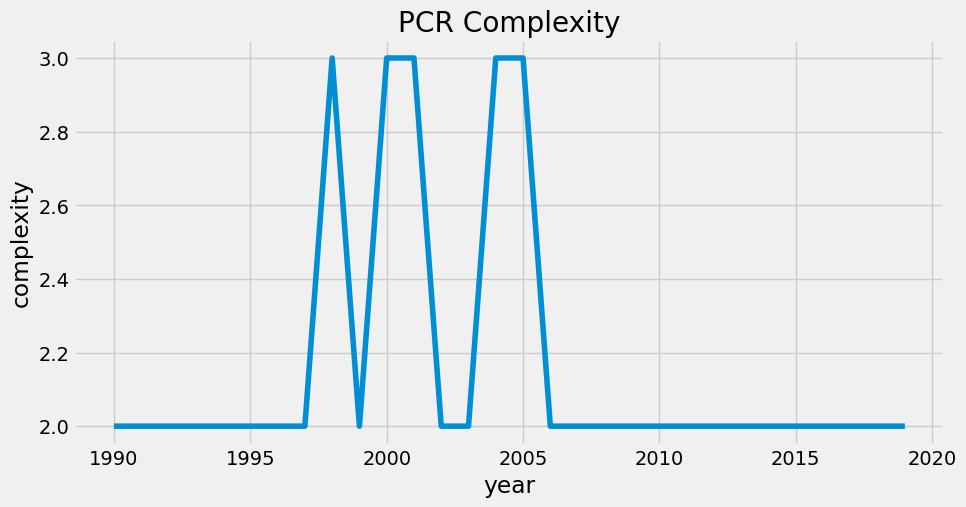

In [8]:
# Model complexities PLS
complexities = [0] * 30
for i, m in enumerate(models):
    complexities[i] = m[1].x_weights_.shape[1]

plt.figure(figsize=(10,5))
plt.title("PCR Complexity")
year=np.arange(1990, 2020)
plt.plot(year, complexities)
plt.xlabel("year")
plt.ylabel("complexity")

In [9]:
#Variable importance
var_importance = np.zeros([30, len(predictors)])
for i in range(30):
    std_scaler, model = models[i][0], models[i][1]
    d = data[(data.yyyymm >= 199001 + i*100) & (data.yyyymm < 199101 + i * 100)]
    X = d[predictors]
    y = d['RET']
    for j in range(len(predictors)):
        X_mod = X.copy()
        X_mod.loc[:, predictors[j]] = 0
        X_mod = std_scaler.transform(X_mod)
        score = r2_score(y, model.predict(X_mod))
        var_importance[i][j] = test_score[i] - score
        del X_mod

<Axes: ylabel='predictor'>

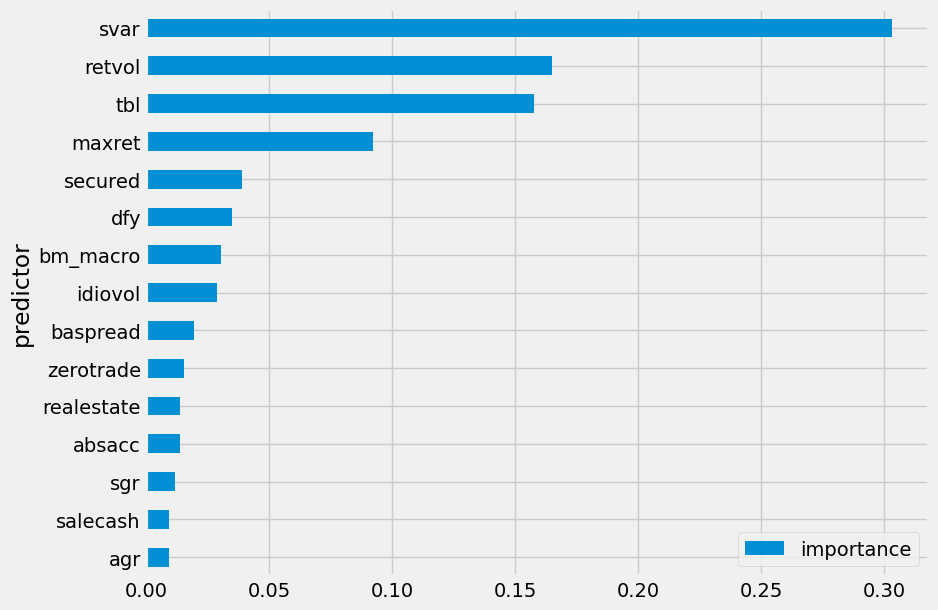

In [10]:
var_importance_agg = var_importance.sum(axis=0)
var_importance_agg[var_importance_agg < 0] = 0
var_importance_agg = var_importance_agg / var_importance_agg.sum()

var_importance_df = pd.DataFrame({'predictor': predictors, 'importance': var_importance_agg})
var_importance_df = var_importance_df.sort_values(by='importance',ascending=True).tail(15)
var_importance_df.plot.barh(x = 'predictor', y = 'importance', figsize = (9, 7))

<Axes: ylabel='predictor'>

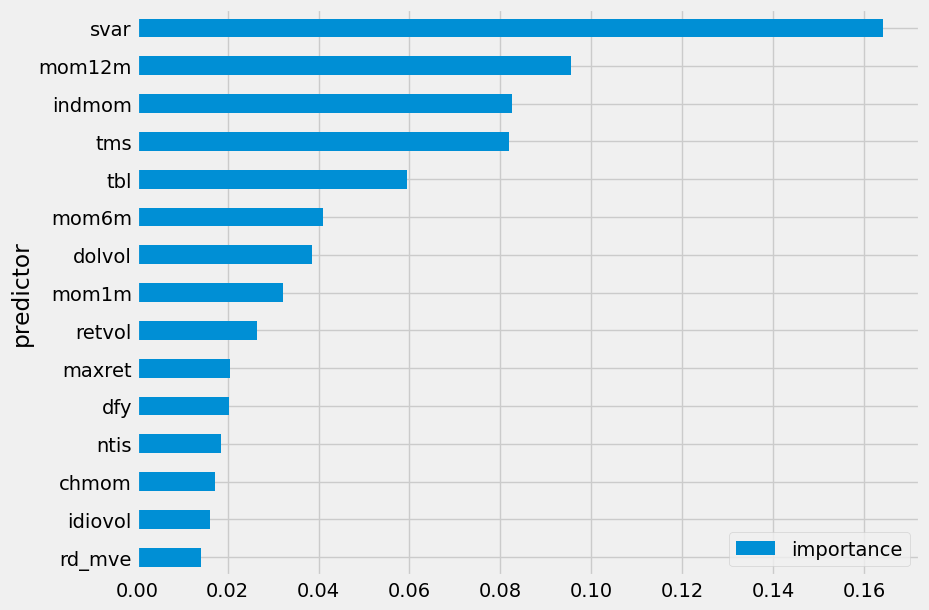

In [11]:
# SSD importance
ssd_list = []
for i, m in enumerate(models):
    ssd_list.append(m[1].coef_.squeeze() ** 2)
ssd_importance = np.array(ssd_list).sum(axis=0)
ssd_importance = ssd_importance / ssd_importance.sum()

ssd_importance_df = pd.DataFrame({'predictor': predictors, 'importance': ssd_importance})
ssd_importance_df = ssd_importance_df.sort_values(by='importance',ascending=True).tail(15)
ssd_importance_df.plot.barh(x = 'predictor', y = 'importance', figsize = (9, 7))